In [1]:
import pandas as pd
import numpy as np
from io import StringIO
import requests
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib

In [6]:

# ------------------------
# 1. Load Dataset from URL
# ------------------------
DATA_URL = "https://raw.githubusercontent.com/mindsdb/mindsdb-examples/master/classics/customer_churn/raw_data/WA_Fn-UseC_-Telco-Customer-Churn.csv"

df = load_data_from_url(DATA_URL)
print("Data loaded, shape:", df.shape)

def load_data_from_url(url: str) -> pd.DataFrame:
    resp = requests.get(url)
    resp.raise_for_status()  # throw exception if HTTP error
    csv_text = resp.text
    df = pd.read_csv(StringIO(csv_text))
    return df

df = load_data_from_url(DATA_URL)
print("Data loaded, shape:", df.shape)

# Drop customerID if present
if "customerID" in df.columns:
    df = df.drop("customerID", axis=1)

# Target
y = df["Churn"].map({"Yes": 1, "No": 0})
X = df.drop("Churn", axis=1)


Data loaded, shape: (7043, 21)
Data loaded, shape: (7043, 21)


In [7]:
# ---------------------------------
# 2. Identify categorical vs numeric
# ---------------------------------
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X.select_dtypes(exclude=["object"]).columns.tolist()


In [8]:
# ------------------------
# 3. Preprocessing pipelines
# ------------------------
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols),
])


In [9]:
# ------------------------
# 4. Define models inside pipelines
# ------------------------
log_reg = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])
rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])


In [10]:
# ------------------------
# 5. Split data
# ------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [11]:
# ------------------------
# 6. Hyperparameter tuning
# ------------------------
param_grid_logreg = {
    "classifier__C": [0.01, 0.1, 1, 10],
    "classifier__penalty": ["l2"]
}
param_grid_rf = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [5, 10, None],
    "classifier__min_samples_split": [2, 5]
}

grid_logreg = GridSearchCV(log_reg, param_grid_logreg, cv=5, scoring="accuracy", n_jobs=-1)
grid_logreg.fit(X_train, y_train)

grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring="accuracy", n_jobs=-1)
grid_rf.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['SeniorCitizen',
                                                                          'tenure',
                                                                          'MonthlyCharges']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['gender',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'PhoneService',
                                                                          'MultipleLines',
                                                                          'InternetService',
                                                                          'O...
                                                                          'OnlineBackup',
                                                                          'DeviceProtection',
                                                                          'TechSupport',
                                                                          'StreamingTV',
                                                                          'StreamingMovies',
                                                                          'Contract',
                                                                          'PaperlessBilling',
                                                                          'PaymentMethod',
                                                                          'TotalCharges'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [5, 10, None],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [100, 200]},
             scoring='accuracy')

In [12]:
# ------------------------
# 7. Evaluate
# ------------------------
print("Best Logistic Regression Params:", grid_logreg.best_params_)
print("Best Random Forest Params:", grid_rf.best_params_)

best_logreg = grid_logreg.best_estimator_
best_rf = grid_rf.best_estimator_

y_pred_log = best_logreg.predict(X_test)
y_pred_rf = best_rf.predict(X_test)

print("\nLogistic Regression Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

print("\nRandom Forest Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Best Logistic Regression Params: {'classifier__C': 0.01, 'classifier__penalty': 'l2'}
Best Random Forest Params: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}

Logistic Regression Performance:
Accuracy: 0.7984386089425124
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1035
           1       0.66      0.50      0.57       374

    accuracy                           0.80      1409
   macro avg       0.75      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409


Random Forest Performance:
Accuracy: 0.78708303761533
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1035
           1       0.64      0.46      0.54       374

    accuracy                           0.79      1409
   macro avg       0.73      0.68      0.70      1409
weighted avg       0.77      0.79      0.78      1409



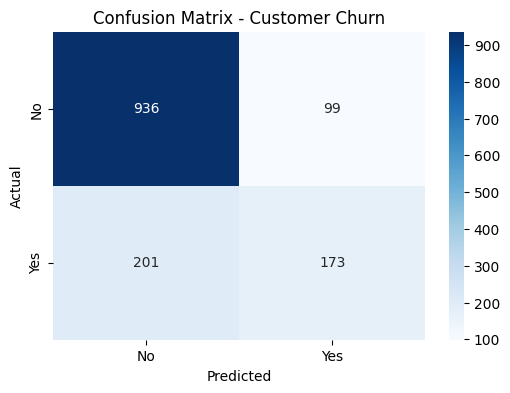

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Customer Churn")
plt.show()

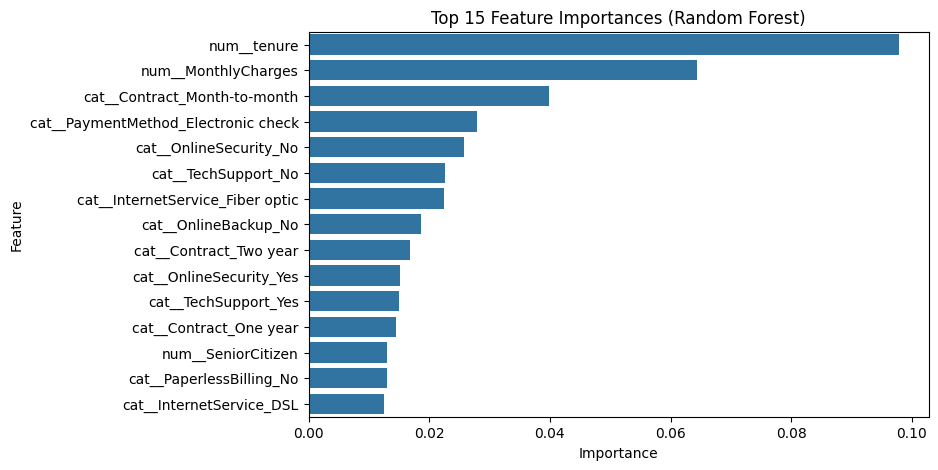

In [19]:
# If pipeline ends with RandomForest
rf_model = best_rf.named_steps['classifier']

importances = rf_model.feature_importances_

# Get feature names after preprocessing
preprocessor = best_rf.named_steps['preprocessor']
feature_names = preprocessor.get_feature_names_out()

# Plot
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:15]

plt.figure(figsize=(8,5))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

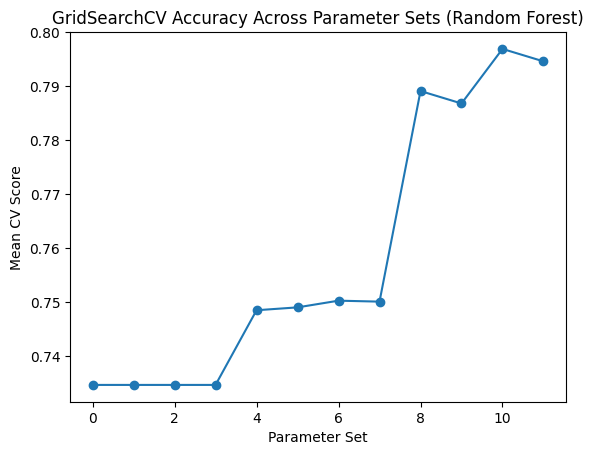

In [22]:
results = pd.DataFrame(grid_rf.cv_results_)
plt.plot(results['mean_test_score'], marker='o')
plt.xlabel("Parameter Set")
plt.ylabel("Mean CV Score")
plt.title("GridSearchCV Accuracy Across Parameter Sets (Random Forest)")
plt.show()

In [13]:
# ------------------------
# 8. Export final model
# ------------------------
final_model = best_rf if accuracy_score(y_test, y_pred_rf) >= accuracy_score(y_test, y_pred_log) else best_logreg
joblib.dump(final_model, "churn_pipeline.pkl")
print("✅ Exported pipeline as churn_pipeline.pkl")


✅ Exported pipeline as churn_pipeline.pkl
